In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.stats import kendalltau

from ml_tb.normalisation import MinMaxScaler
from ml_tb.metrics import RMSE_denormalised_P, RMSE_denormalised_T, RMSE_denormalised_temperature_only, k_tau_sequences
from ml_tb.validation import load_k_models, predict_on_val_set
from ml_tb.plot import zone_to_number, plot_sequence_locality

In [2]:
# Load the data
data = pd.read_excel(Path("validation_data_sequences.xlsx"))

In [3]:
# define the custom metrics
scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0)
inv_scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0, invert=True)

def RMSE_P(y_true, y_pred):
    return RMSE_denormalised_P(y_true, y_pred, inv_scaling_pt)

def RMSE_T(y_true, y_pred):
    return RMSE_denormalised_T(y_true, y_pred, inv_scaling_pt)

In [4]:
models_MnFMAST = load_k_models("AA_k_MnFMAST", Path("01_fit_natural_biotite", "saved_models"), [RMSE_T, RMSE_P])

models_ds62 = load_k_models("model_ds62White2014", Path("02_pretraining", "saved_models"), [RMSE_T, RMSE_P], k_models=False)
models_ds55Bt07 = load_k_models("model_ds55White2007", Path("02_pretraining", "saved_models"), [RMSE_T, RMSE_P], k_models=False)
models_ds55BtT = load_k_models("model_ds55Tajcmanova2009", Path("02_pretraining", "saved_models"), [RMSE_T, RMSE_P], k_models=False)

models_transfers_ds62 = load_k_models("k_ds62", Path("03_transfer_learning", "saved_models"), [RMSE_T, RMSE_P])
models_transfers_ds55Bt07 = load_k_models("k_ds55Bt07", Path("03_transfer_learning", "saved_models"), [RMSE_T, RMSE_P])
models_transfers_ds55BtT = load_k_models("k_ds55BtT", Path("03_transfer_learning", "saved_models"), [RMSE_T, RMSE_P])

In [5]:
sequences = ["N Bavaria (Moldanubian)", "Harpswell Neck, USA",
             "Leech River", "Pichilemu", "Kluane", "Quesnel Lake",
             "Sierra de Guadarrama", "Clachncuydainn", "Saglek", "El Oro"]

tau_pressure_weighted_MnFMAST, tau_temperature_weighted_MnFMAST = k_tau_sequences(data, models_MnFMAST, inv_scaling_pt, sequences)
tau_pressure_weighted_ds62, tau_temperature_weighted_ds62 = k_tau_sequences(data, models_ds62, inv_scaling_pt, sequences)
tau_pressure_weighted_ds55Bt07, tau_temperature_weighted_ds55Bt07 = k_tau_sequences(data, models_ds55Bt07, inv_scaling_pt, sequences)
tau_pressure_weighted_ds55BtT, tau_temperature_weighted_ds55BtT = k_tau_sequences(data, models_ds55BtT, inv_scaling_pt, sequences)

tau_pressure_weighted_transfers_ds62, tau_temperature_weighted_transfers_ds62 = k_tau_sequences(data, models_transfers_ds62, inv_scaling_pt, sequences)
tau_pressure_weighted_transfers_ds55Bt07, tau_temperature_weighted_transfers_ds55Bt07 = k_tau_sequences(data, models_transfers_ds55Bt07, inv_scaling_pt, sequences)
tau_pressure_weighted_transfers_ds55BtT, tau_temperature_weighted_transfers_ds55BtT = k_tau_sequences(data, models_transfers_ds55BtT, inv_scaling_pt, sequences)

/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_38846/1503954675.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot([tau_temperature_weighted_MnFMAST, tau_temperature_weighted_transfers_ds62, tau_temperature_weighted_transfers_ds55Bt07, tau_temperature_weighted_transfers_ds55BtT], labels=["MnFMAST", "ds62_transfer", "ds55Bt07_transfer", "ds55BtT_transfer"])
/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_38846/1503954675.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([tau_pressure_weighted_MnFMAST, tau_pressure_weighted_transfers_ds62, tau_pressure_weighted_transfers_ds55Bt07, tau_pressure_weighted_transfers_ds55BtT], labels=["MnFMAST", "ds62_transfer", "ds55Bt07_transfer", "ds55BtT

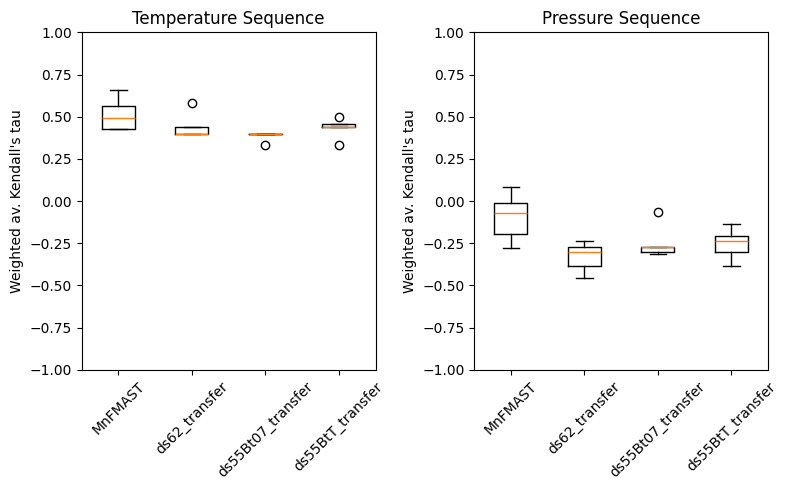

In [6]:
# plot the tau for each model set
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

axs[0].boxplot([tau_temperature_weighted_MnFMAST, tau_temperature_weighted_transfers_ds62, tau_temperature_weighted_transfers_ds55Bt07, tau_temperature_weighted_transfers_ds55BtT], labels=["MnFMAST", "ds62_transfer", "ds55Bt07_transfer", "ds55BtT_transfer"])
axs[0].set_ylabel("Weighted av. Kendall's tau")
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45)
axs[0].set_ylim(-1, 1)
axs[0].set_title("Temperature Sequence")

axs[1].boxplot([tau_pressure_weighted_MnFMAST, tau_pressure_weighted_transfers_ds62, tau_pressure_weighted_transfers_ds55Bt07, tau_pressure_weighted_transfers_ds55BtT], labels=["MnFMAST", "ds62_transfer", "ds55Bt07_transfer", "ds55BtT_transfer"])
axs[1].set_ylabel("Weighted av. Kendall's tau")
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)
axs[1].set_ylim(-1, 1)
axs[1].set_title("Pressure Sequence")

fig.tight_layout()
# fig.savefig(Path("exported_figs_sequence", "k_tau_transfer_learning.pdf"), dpi=600)

In [7]:
print("Kendall's tau for the temperature sequence")
print("MnFMAST median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_temperature_weighted_MnFMAST), np.min(tau_temperature_weighted_MnFMAST), np.max(tau_temperature_weighted_MnFMAST)))
print("transfer ds62 median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_temperature_weighted_transfers_ds62), np.min(tau_temperature_weighted_transfers_ds62), np.max(tau_temperature_weighted_transfers_ds62)))
print("transfer ds55Bt07 median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_temperature_weighted_transfers_ds55Bt07), np.min(tau_temperature_weighted_transfers_ds55Bt07), np.max(tau_temperature_weighted_transfers_ds55Bt07)))
print("transfer ds55BtT median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_temperature_weighted_transfers_ds55BtT), np.min(tau_temperature_weighted_transfers_ds55BtT), np.max(tau_temperature_weighted_transfers_ds55BtT)))

print("Kendall's tau for the pressure sequence")
print("MnFMAST median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_pressure_weighted_MnFMAST), np.min(tau_pressure_weighted_MnFMAST), np.max(tau_pressure_weighted_MnFMAST)))
print("transfer ds62 median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_pressure_weighted_transfers_ds62), np.min(tau_pressure_weighted_transfers_ds62), np.max(tau_pressure_weighted_transfers_ds62)))
print("transfer ds55Bt07 median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_pressure_weighted_transfers_ds55Bt07), np.min(tau_pressure_weighted_transfers_ds55Bt07), np.max(tau_pressure_weighted_transfers_ds55Bt07)))
print("transfer ds55BtT median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_pressure_weighted_transfers_ds55BtT), np.min(tau_pressure_weighted_transfers_ds55BtT), np.max(tau_pressure_weighted_transfers_ds55BtT)))

Kendall's tau for the temperature sequence
MnFMAST median = 0.49; range: 0.43-0.66
transfer ds62 median = 0.40; range: 0.40-0.58
transfer ds55Bt07 median = 0.40; range: 0.33-0.40
transfer ds55BtT median = 0.44; range: 0.33-0.50
Kendall's tau for the pressure sequence
MnFMAST median = -0.07; range: -0.28-0.08
transfer ds62 median = -0.30; range: -0.46--0.24
transfer ds55Bt07 median = -0.27; range: -0.31--0.06
transfer ds55BtT median = -0.24; range: -0.39--0.14


In [8]:
_, _, p_pres_matrix_MnFMAST, p_temp_matrix_MnFMAST  = k_tau_sequences(data, models_MnFMAST, inv_scaling_pt, sequences, return_p_values=True)

_, _, p_pres_matrix_transfers_ds62, p_temp_matrix_transfers_ds62 = k_tau_sequences(data, models_transfers_ds62, inv_scaling_pt, sequences, return_p_values=True)
_, _, p_pres_matrix_transfers_ds55Bt07, p_temp_matrix_transfers_ds55Bt07 = k_tau_sequences(data, models_transfers_ds55Bt07, inv_scaling_pt, sequences, return_p_values=True)
_, _, p_pres_matrix_transfers_ds55BtT, p_pres_matrix_transfers_ds55BtT = k_tau_sequences(data, models_transfers_ds55BtT, inv_scaling_pt, sequences, return_p_values=True)

In [9]:
p_pres_matrix_transfers_ds62

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.75      , 0.75      , 0.75      , 0.75      , 0.75      ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.33333333, 0.33333333, 1.        ],
       [0.33333333, 0.33333333, 0.33333333, 0.33333333, 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.08333333, 0.23333333, 0.48333333, 0.08333333, 0.48333333],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 0.33333333, 0.33333333],
       [0.23333333, 0.23333333, 0.23333333, 0.48333333, 0.23333333]])

In [10]:
p_temp_matrix_MnFMAST

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.33333333, 0.08333333, 0.33333333, 0.33333333, 0.08333333],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 0.33333333, 1.        , 1.        , 0.33333333],
       [0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.01666667]])

# Plotting of sequence predictions for n example sequence (Quesnel Lake, Canada)

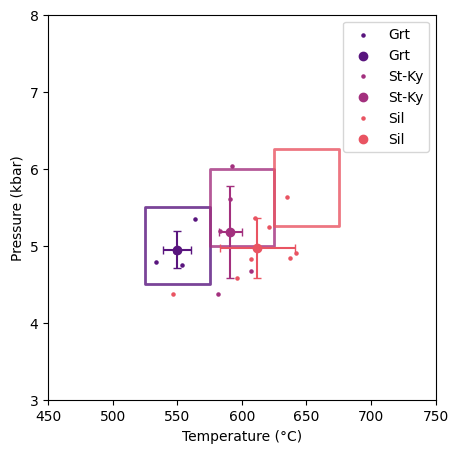

In [11]:
fig, ax = plot_sequence_locality(data, "Quesnel Lake", models_MnFMAST[1], "magma")

ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Pressure (kbar)")

ax.set_xlim(450, 750)
ax.set_ylim(3, 8)

fig.set_size_inches(5, 5)

ax.legend()

# fig.savefig(Path("exported_figs_sequence", "Quesnel_ref.pdf"), dpi=600)

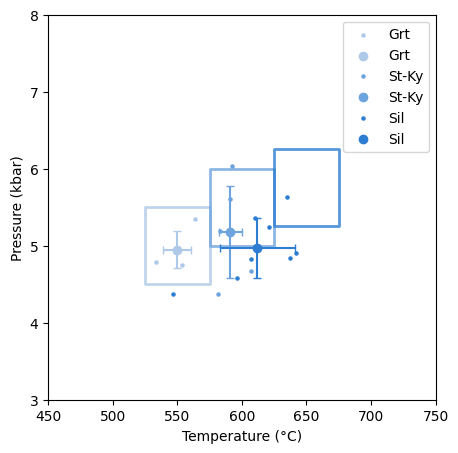

In [12]:
fig, ax = plot_sequence_locality(data, "Quesnel Lake", models_MnFMAST[1], sns.color_palette("light:#2D7DD2", n_colors=7))

ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Pressure (kbar)")

ax.set_xlim(450, 750)
ax.set_ylim(3, 8)

fig.set_size_inches(5, 5)

ax.legend()
# fig.savefig(Path("exported_figs_sequence", "Quesnel_MnFMAST.pdf"), dpi=600)

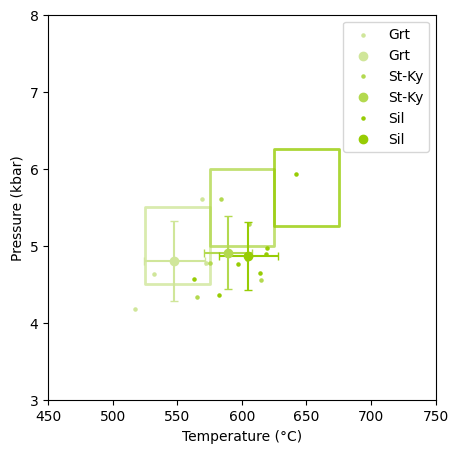

In [13]:
fig, ax = plot_sequence_locality(data, "Quesnel Lake", models_transfers_ds62[1], sns.color_palette("light:#97CC04", n_colors=7))

ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Pressure (kbar)")

ax.set_xlim(450, 750)
ax.set_ylim(3, 8)

fig.set_size_inches(5, 5)

ax.legend()
# fig.savefig(Path("exported_figs_sequence", "Quesnel_ds62.pdf"), dpi=600)

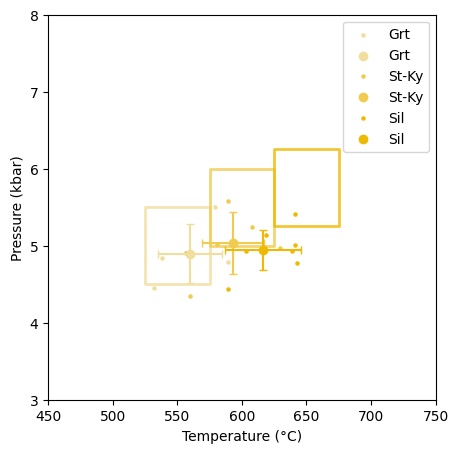

In [14]:
fig, ax = plot_sequence_locality(data, "Quesnel Lake", models_transfers_ds55Bt07[1], sns.color_palette("light:#EEB902", n_colors=7))

ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Pressure (kbar)")

ax.set_xlim(450, 750)
ax.set_ylim(3, 8)

fig.set_size_inches(5, 5)

ax.legend()
# fig.savefig(Path("exported_figs_sequence", "Quesnel_ds55Bt07.pdf"), dpi=600)

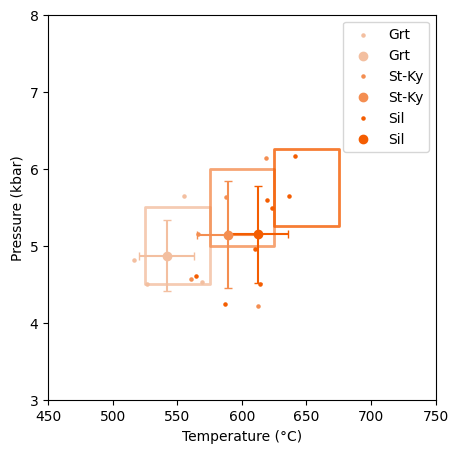

In [15]:
fig, ax = plot_sequence_locality(data, "Quesnel Lake", models_transfers_ds55BtT[1], sns.color_palette("light:#F45D01", n_colors=7))

ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Pressure (kbar)")

ax.set_xlim(450, 750)
ax.set_ylim(3, 8)

fig.set_size_inches(5, 5)

ax.legend()
# fig.savefig(Path("exported_figs_sequence", "Quesnel_ds55BtT.pdf"), dpi=600)

## Check for sequences >2 zones.

Some MAS in the test dataset only show two zones. This questions the validity of the sequence, since there is little constraint how potential gradients in metamorphic grade are oriented. To check for this, Kendall's tau is calculated seperately for the sequences with more than two zones.

In [16]:
sequences = ["Harpswell Neck, USA",
             "Leech River", "Pichilemu", "Kluane", "Quesnel Lake",
             "Sierra de Guadarrama", "Saglek", "El Oro"]

tau_pressure_weighted_MnFMAST, tau_temperature_weighted_MnFMAST = k_tau_sequences(data, models_MnFMAST, inv_scaling_pt, sequences)

tau_pressure_weighted_transfers_ds62, tau_temperature_weighted_transfers_ds62 = k_tau_sequences(data, models_transfers_ds62, inv_scaling_pt, sequences)
tau_pressure_weighted_transfers_ds55Bt07, tau_temperature_weighted_transfers_ds55Bt07 = k_tau_sequences(data, models_transfers_ds55Bt07, inv_scaling_pt, sequences)
tau_pressure_weighted_transfers_ds55BtT, tau_temperature_weighted_transfers_ds55BtT = k_tau_sequences(data, models_transfers_ds55BtT, inv_scaling_pt, sequences)

In [17]:
print("Kendall's tau for the temperature sequence")
print("MnFMAST median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_temperature_weighted_MnFMAST), np.min(tau_temperature_weighted_MnFMAST), np.max(tau_temperature_weighted_MnFMAST)))
print("transfer ds62 median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_temperature_weighted_transfers_ds62), np.min(tau_temperature_weighted_transfers_ds62), np.max(tau_temperature_weighted_transfers_ds62)))
print("transfer ds55Bt07 median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_temperature_weighted_transfers_ds55Bt07), np.min(tau_temperature_weighted_transfers_ds55Bt07), np.max(tau_temperature_weighted_transfers_ds55Bt07)))
print("transfer ds55BtT median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_temperature_weighted_transfers_ds55BtT), np.min(tau_temperature_weighted_transfers_ds55BtT), np.max(tau_temperature_weighted_transfers_ds55BtT)))

print("Kendall's tau for the pressure sequence")
print("MnFMAST median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_pressure_weighted_MnFMAST), np.min(tau_pressure_weighted_MnFMAST), np.max(tau_pressure_weighted_MnFMAST)))
print("transfer ds62 median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_pressure_weighted_transfers_ds62), np.min(tau_pressure_weighted_transfers_ds62), np.max(tau_pressure_weighted_transfers_ds62)))
print("transfer ds55Bt07 median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_pressure_weighted_transfers_ds55Bt07), np.min(tau_pressure_weighted_transfers_ds55Bt07), np.max(tau_pressure_weighted_transfers_ds55Bt07)))
print("transfer ds55BtT median = {:.2f}; range: {:.2f}-{:.2f}".format(np.median(tau_pressure_weighted_transfers_ds55BtT), np.min(tau_pressure_weighted_transfers_ds55BtT), np.max(tau_pressure_weighted_transfers_ds55BtT)))

Kendall's tau for the temperature sequence
MnFMAST median = 0.63; range: 0.56-0.79
transfer ds62 median = 0.60; range: 0.60-0.67
transfer ds55Bt07 median = 0.60; range: 0.52-0.60
transfer ds55BtT median = 0.64; range: 0.52-0.71
Kendall's tau for the pressure sequence
MnFMAST median = -0.08; range: -0.32--0.01
transfer ds62 median = -0.20; range: -0.38--0.13
transfer ds55Bt07 median = -0.17; range: -0.36--0.07
transfer ds55BtT median = -0.13; range: -0.30--0.01
